### Loading the cancer dataset into the R kernel

In [230]:
library(e1071)
library(rlist)
library(plyr)
library(dplyr)
highskew_threshold=3
cancer = read.csv(file="/Users/axpatel/Downloads/cancer.csv", header=TRUE, sep=",")

### Summarizing the given dataset.

In [231]:
paste("The dataset contains the following parameters: ", paste(names(cancer), collapse=", "))
paste("The number of data points are: ", paste(nrow(cancer)))
print(summary(cancer))

[1] "The dataset contains the following parameters:  X, avgAnnCount, medIncome, popEst2015, povertyPercent, binnedInc, MedianAge, MedianAgeMale, MedianAgeFemale, Geography, AvgHouseholdSize, PercentMarried, PctNoHS18_24, PctHS18_24, PctSomeCol18_24, PctBachDeg18_24, PctHS25_Over, PctBachDeg25_Over, PctEmployed16_Over, PctUnemployed16_Over, PctPrivateCoverage, PctEmpPrivCoverage, PctPublicCoverage, PctWhite, PctBlack, PctAsian, PctOtherRace, PctMarriedHouseholds, BirthRate, deathRate"

[1] "The number of data points are:  3047"

       X           avgAnnCount        medIncome        popEst2015      
 Min.   :   1.0   Min.   :    6.0   Min.   : 22640   Min.   :     827  
 1st Qu.: 762.5   1st Qu.:   76.0   1st Qu.: 38882   1st Qu.:   11684  
 Median :1524.0   Median :  171.0   Median : 45207   Median :   26643  
 Mean   :1524.0   Mean   :  606.3   Mean   : 47063   Mean   :  102637  
 3rd Qu.:2285.5   3rd Qu.:  518.0   3rd Qu.: 52492   3rd Qu.:   68671  
 Max.   :3047.0   Max.   :38150.0   Max.   :125635   Max.   :10170292  
                                                                       
 povertyPercent               binnedInc      MedianAge      MedianAgeMale  
 Min.   : 3.20   (45201, 48021.6]  : 306   Min.   : 22.30   Min.   :22.40  
 1st Qu.:12.15   (54545.6, 61494.5]: 306   1st Qu.: 37.70   1st Qu.:36.35  
 Median :15.90   [22640, 34218.1]  : 306   Median : 41.00   Median :39.60  
 Mean   :16.88   (42724.4, 45201]  : 305   Mean   : 45.27   Mean   :39.57  
 3rd Qu.:20.40   (48021.6, 51046.4]: 305   3

Based on the descriptive statistics, few of the fileds have highly skewed data and a couple of fields are missing values. Next, let's find the fields with high skew values and missing parameters. 

In [278]:
# Applying Pearson's moment coefficient to measyre the skewness (Ref: https://en.wikipedia.org/wiki/Skewness).
field_na = list()
field_skew = list()
high_skew = list()
for (col in names(cancer)){
    if(class(cancer[,col]) == "numeric"){
        skew = skewness(cancer[,col], na.rm=TRUE)
        x = c(col, skew)
        names(x) = c("field", "skew")
        field_skew = list.append(field_skew, x)
        if(skew >=highskew_threshold | skew<=(-1 * highskew_threshold)){
            high_skew = list.append(high_skew, x)
        }
    }
    if(any(is.na(cancer[,col]))){
        y = c(col, sum(is.na(cancer[,col]))/nrow(cancer))
        names(y) = c('field', '%_na')
        field_na = list.append(field_na, y)
    }
}
paste("Parameters with high skew values", paste(high_skew, collapse=", "))
paste("Parameters with missing values", paste(field_na, collapse=", "))

[1] "Parameters with high skew values c(field = \"avgAnnCount\", skew = \"10.6699469231418\"), c(field = \"MedianAge\", skew = \"9.98011048305904\"), c(field = \"AvgHouseholdSize\", skew = \"-3.37765974286406\"), c(field = \"PctAsian\", skew = \"7.41073850927254\"), c(field = \"PctOtherRace\", skew = \"4.94730473909713\")"

[1] "Parameters with missing values c(field = \"PctSomeCol18_24\", `%_na` = \"0.749917952084017\"), c(field = \"PctEmployed16_Over\", `%_na` = \"0.0498851329176239\")"

Any field with Pearson's coefficient larger/smaller than a threshold (highskew_threshold=3) is classified as a field with considerable right/left-skewed distribution. The potential causes may be (1) the existance of anomalies or (2) errornous data reporting. One approach to understand the distributin is to visualize data distribitions.

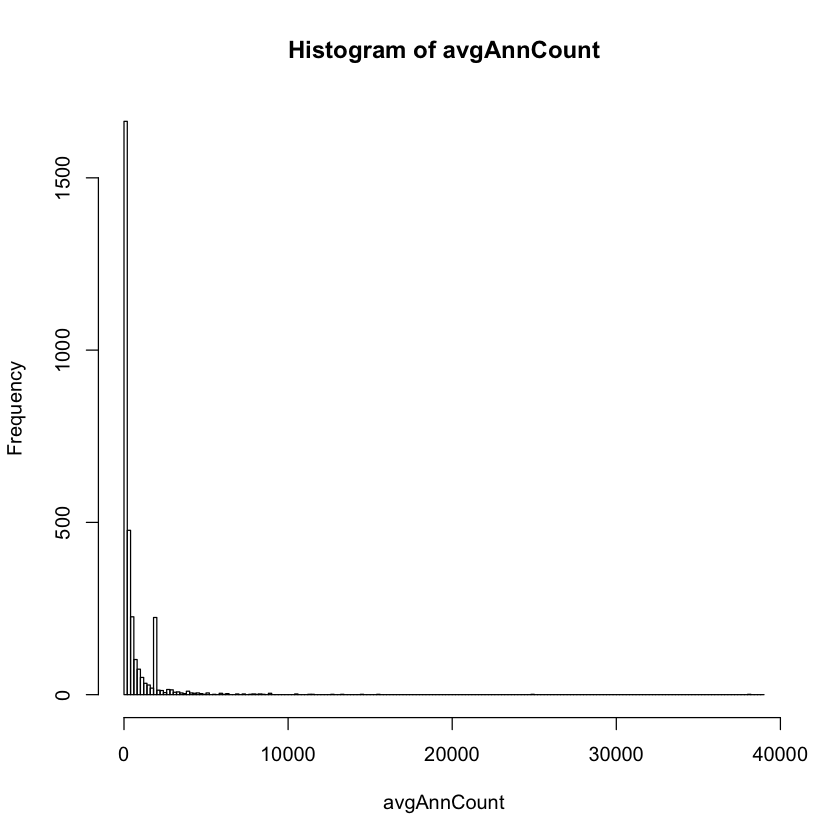

In [289]:
hist(cancer$avgAnnCount, breaks=seq(0, 39000, by=200), main="Histogram of avgAnnCount", xlab="avgAnnCount", ylab='Frequency')

In [274]:
paste(length(filter(cancer, avgAnnCount >= 1962 & avgAnnCount < 1963)[['Geography']]), "counties are found with identical value of avgAnnCount, 1962.668")

[1] "Number of counties with identical value of avgAnnCount 206"

An unusual spike is observed in the range of (1800, 1900) within the long tail of the distribution. The data contributing the distribution is likely to be erronous for the following reasons; (1) there is an identical value of avgAnnCount for a set of counties and (2) For some counties the avgAnnCount is higher than popEst2015 which cannot be plusible.

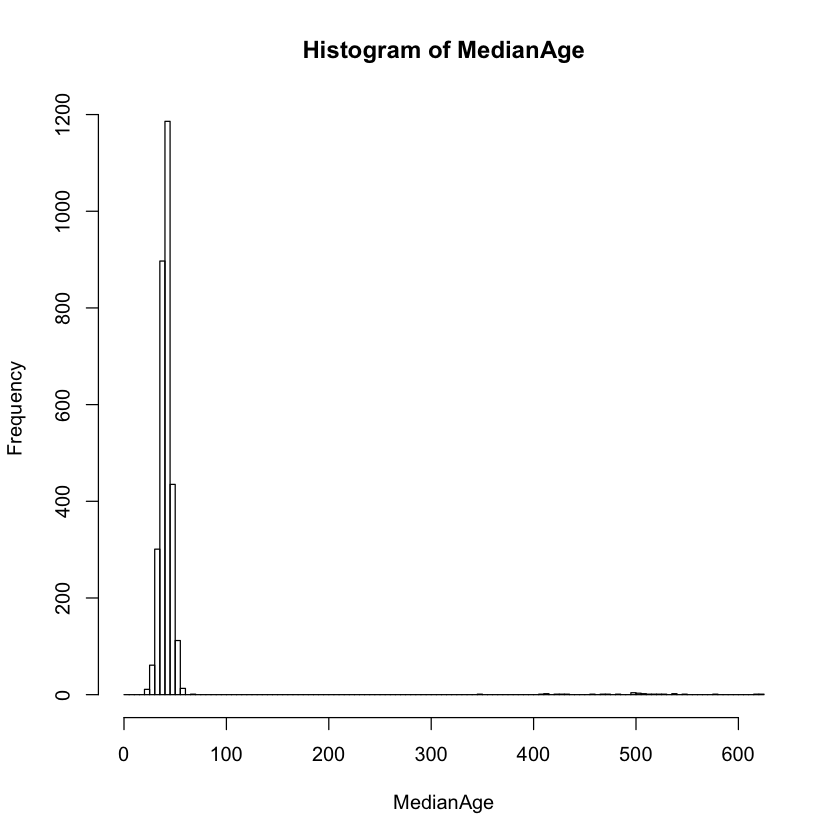

In [290]:
hist(cancer$MedianAge, breaks=seq(0, 625, by=5), main="Histogram of MedianAge", xlab="MedianAge", ylab='Frequency')

In [277]:
paste(length(filter(cancer, MedianAge > 125)[['Geography']]), "counties have median age higher than 125.")

[1] "30 counties have median age higher than 125."

The distribution of MedianAge is skewed due to some erronous records of MedianAge from 30 counties.


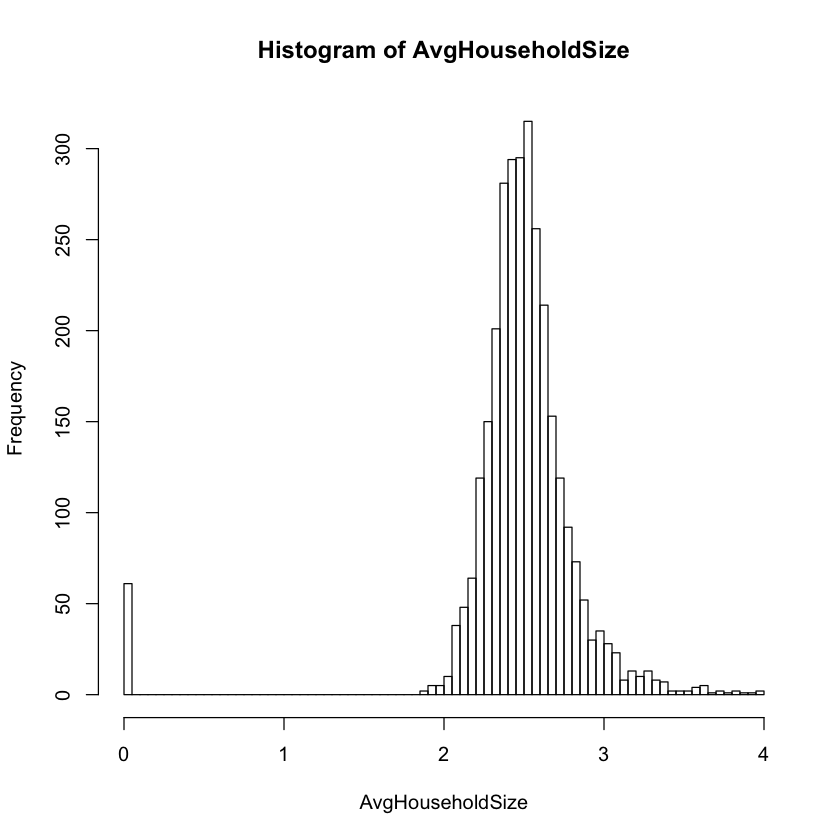

In [291]:
hist(cancer$AvgHouseholdSize, breaks=100, main="Histogram of AvgHouseholdSize", xlab="AvgHouseholdSize", ylab='Frequency')

In [300]:
paste("Number of houses with average size smaller than 0.03 are: ", length(filter(cancer, AvgHouseholdSize < 0.03)[['AvgHouseholdSize']]))
paste("Number of houses with average size greater than 3.8 are: ", length(filter(cancer, AvgHouseholdSize > 3.8)[['AvgHouseholdSize']]))

[1] "Number of houses with average size smaller than 0.03 are:  59"

[1] "Number of houses with average size greater than 3.8 are:  6"

There is no data issue observed in the distribution of the average house size (AvgHouseholdSize). The data contains ourliers both at the lower and higher ends of the distributins. The number of houses with average size smaller than 0.03 and greater than 3.8 are 59 and 6 respectively. These outliers contributes to skewness in the distribution.

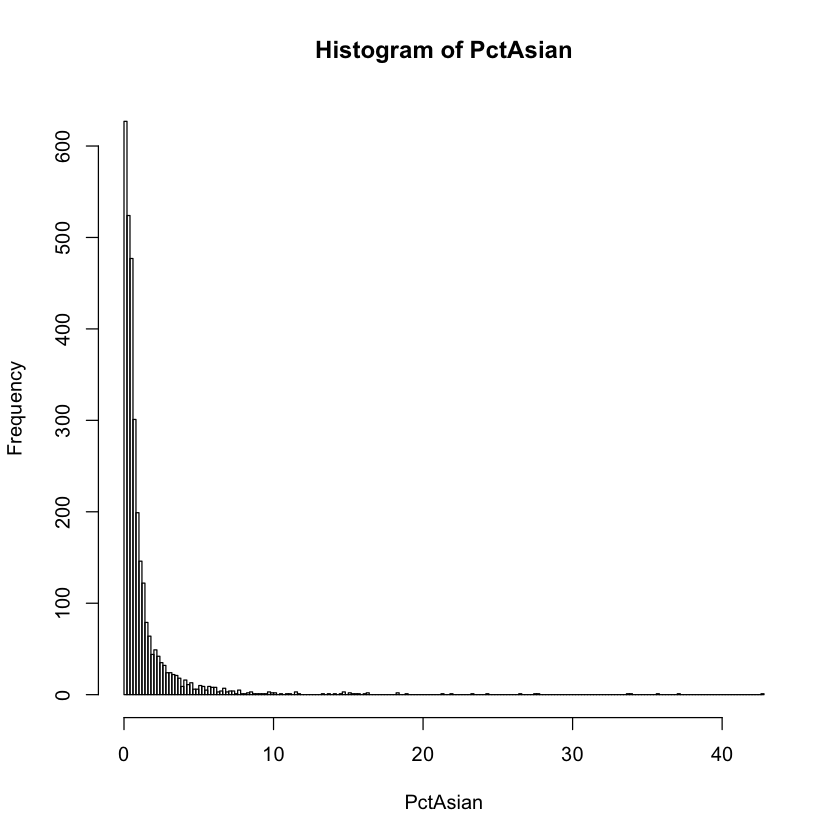

In [305]:
hist(cancer$PctAsian, breaks=200, main="Histogram of PctAsian", xlab="PctAsian", ylab='Frequency')

There is no data issue found for the percentage of Asian (PctAsian). The heave tail represents high concentration of Asians in some of the counties.

In [ ]:
hist(cancer$PctAsian, breaks=200, main="Histogram of PctAsian", xlab="PctAsian", ylab='Frequency')